# Problem Statement

Age : Age of the patient

Sex : Sex of the patient

exang: exercise induced angina (1 = yes; 0 = no)

ca: number of major vessels (0-3)

cp : Chest Pain type chest pain type

Value 1: typical angina
Value 2: atypical angina
Value 3: non-anginal pain
Value 4: asymptomatic
trtbps : resting blood pressure (in mm Hg)

chol : cholestoral in mg/dl fetched via BMI sensor

fbs : (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)

rest_ecg : resting electrocardiographic results

Value 0: normal
Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria
thalach : maximum heart rate achieved

target : 0= less chance of heart attack 1= more chance of heart attack

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler,Normalizer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import KFold, cross_validate,cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.feature_selection import SequentialFeatureSelector, SelectKBest, chi2, SelectFromModel,mutual_info_classif
from sklearn.feature_selection import VarianceThreshold, RFE
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis,QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC,LinearSVC
import warnings
warnings.filterwarnings("ignore")

In [2]:
df=pd.read_csv('Datasets\Heart.csv')
df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


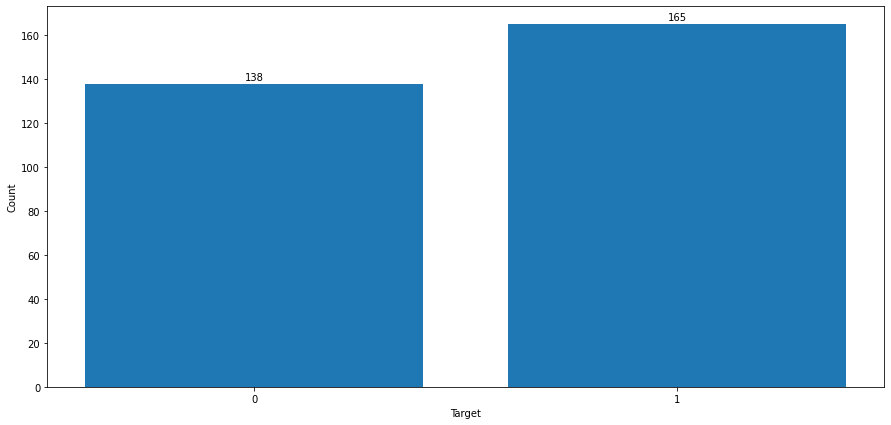

In [3]:
fig,ax=plt.subplots(figsize=(15,7))
ax.bar(df.target.value_counts().index,df.target.value_counts().values)
ax.set_xlabel('Target')
ax.set_ylabel('Count')
ax.set_xticks([0,1])
for p in ax.patches:
    h = p.get_height()
    x = p.get_x()+p.get_width()/2
    ax.annotate("%g" % p.get_height(), xy=(x,h), xytext=(0,2),textcoords="offset points", ha="center", va="bottom")

**Observation:** Class labels are not equal. hence we cannot use accuracy as our evaluation metric. We will use recall, precision or f1-score.

**We will split the dataset into test and train before we do null value imputation or any analysis to avoid data leakage**

In [4]:
x=df[[x for x in df.columns if x !='target']]
y=df[['target']]

In [5]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.3,random_state=1)

In [6]:
train=x_train.join(y_train)
test=x_test.join(y_test)

In [7]:
# Checking null counts in train and test data

train_null_counts=pd.DataFrame(train.isnull().sum(),columns=['train_null_count'])
train_null_counts=train_null_counts.loc[train_null_counts.train_null_count>0]
test_null_counts=pd.DataFrame(test.isnull().sum(),columns=['test_null_count'])
test_null_counts=test_null_counts.loc[test_null_counts.test_null_count>0]
null_counts=test_null_counts.join(train_null_counts).fillna(0)
null_counts['train_null_%']=round((null_counts['train_null_count']/train.shape[0])*100,2)
null_counts['test_null_%']=round((null_counts['test_null_count']/test.shape[0])*100,2)
null_counts

,test_null_count,train_null_count,train_null_%,test_null_%


**Observation:** There are no null values

In [8]:
train.info(),print('************************************************************************'),train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 212 entries, 34 to 37
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       212 non-null    int64  
 1   sex       212 non-null    int64  
 2   cp        212 non-null    int64  
 3   trestbps  212 non-null    int64  
 4   chol      212 non-null    int64  
 5   fbs       212 non-null    int64  
 6   restecg   212 non-null    int64  
 7   thalach   212 non-null    int64  
 8   exang     212 non-null    int64  
 9   oldpeak   212 non-null    float64
 10  slope     212 non-null    int64  
 11  ca        212 non-null    int64  
 12  thal      212 non-null    int64  
 13  target    212 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 32.9 KB
************************************************************************
<class 'pandas.core.frame.DataFrame'>
Int64Index: 212 entries, 34 to 37
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
--

(None, None, None)

**Observation:** There are no categorical features

In [9]:
cor_mat=train.corr()
cor_mat

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
age,1.000000,-0.065126,-0.045037,0.259810,0.171425,0.121625,-0.102768,-0.408601,0.154351,0.177040,-0.127725,0.279356,0.105281,-0.248157
sex,-0.065126,1.000000,-0.051197,-0.046339,-0.118265,-0.002365,-0.090324,-0.014724,0.152412,0.120570,-0.038438,0.123048,0.235788,-0.270014
cp,-0.045037,-0.051197,1.000000,0.112749,-0.096576,0.091884,0.033329,0.299936,-0.391863,-0.096586,0.145140,-0.161289,-0.167741,0.471307
trestbps,0.259810,-0.046339,0.112749,1.000000,0.162960,0.180436,-0.105197,-0.019311,0.060920,0.221796,-0.129385,0.050557,0.059628,-0.135487
chol,0.171425,-0.118265,-0.096576,0.162960,1.000000,0.063347,-0.191908,-0.008512,0.090892,0.059440,-0.001680,0.116056,0.138810,-0.130103
fbs,0.121625,-0.002365,0.091884,0.180436,0.063347,1.000000,-0.065104,-0.028247,0.025938,0.030771,-0.035148,0.135607,-0.043278,-0.021867
restecg,-0.102768,-0.090324,0.033329,-0.105197,-0.191908,-0.065104,1.000000,0.062487,-0.073505,-0.073294,0.096493,-0.121675,-0.003730,0.177532
thalach,-0.408601,-0.014724,0.299936,-0.019311,-0.008512,-0.028247,0.062487,1.000000,-0.391805,-0.352833,0.359759,-0.229240,-0.065187,0.451847
exang,0.154351,0.152412,-0.391863,0.060920,0.090892,0.025938,-0.073505,-0.391805,1.000000,0.371622,-0.319389,0.145243,0.232885,-0.493649
oldpeak,0.177040,0.120570,-0.096586,0.221796,0.059440,0.030771,-0.073294,-0.352833,0.371622,1.000000,-0.572969,0.116132,0.185576,-0.434388


<AxesSubplot:>

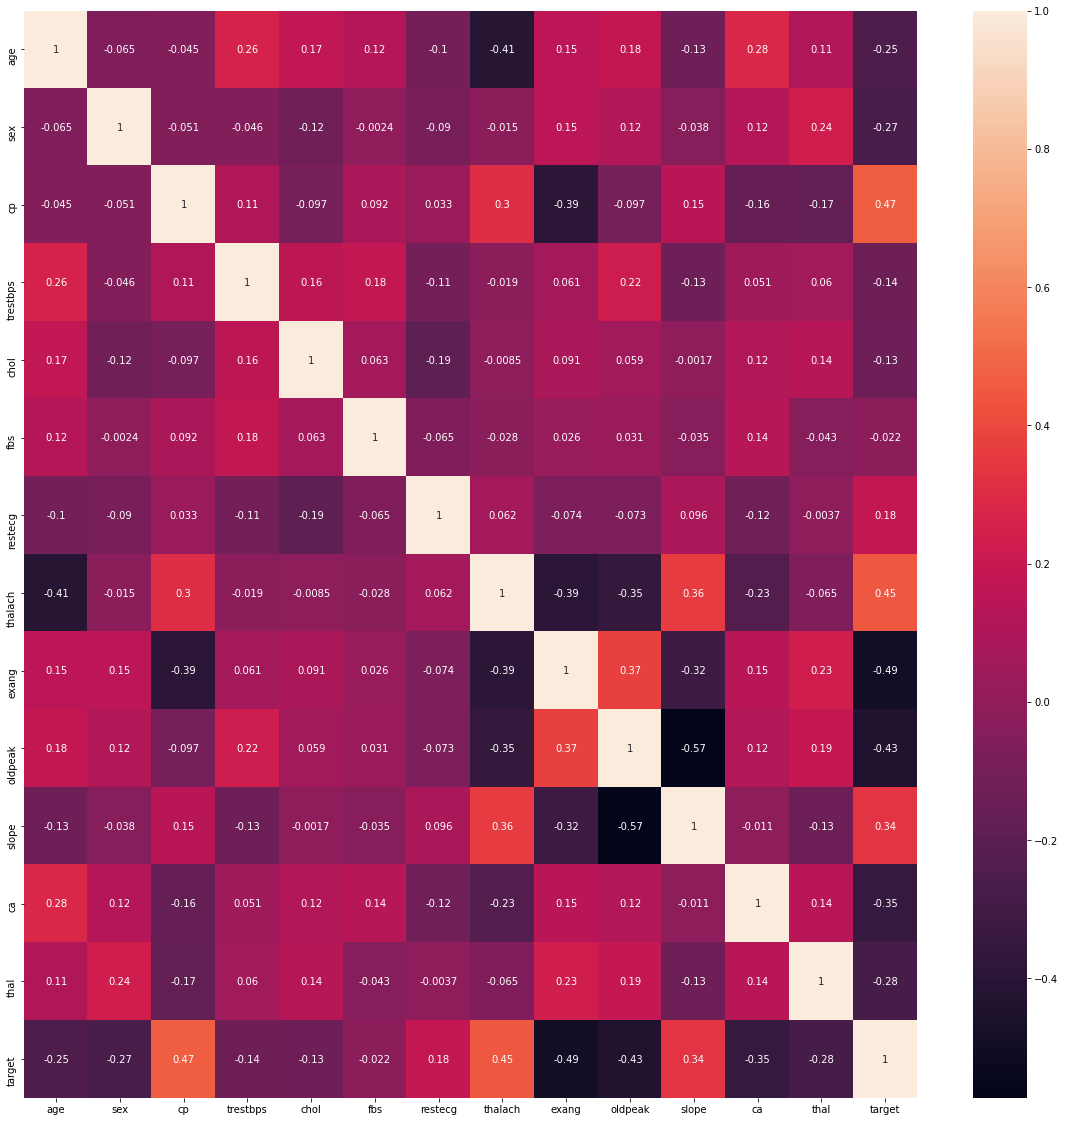

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
fig,ax=plt.subplots(figsize=(20,20))
sns.heatmap(cor_mat,annot=True)

In [11]:
x=train[[x for x in train.columns if x !='target']]
y=train[['target']]

xx=test[[x for x in test.columns if x !='target']]
yy=test[['target']]

In [12]:
models=[LogisticRegression(random_state=1),LinearDiscriminantAnalysis(),LinearSVC(random_state=1),
        RandomForestClassifier(random_state=1),BaggingClassifier(random_state=1)]
scales=[RobustScaler(),StandardScaler(),Normalizer()]
result=[]
for model in models:
    final=[]
    for scale in scales:
        pipe=Pipeline([('scale',scale),('model',model)])
        score=cross_val_score(estimator=pipe,X=x,y=np.array(y).ravel(),cv=5,n_jobs=-1,scoring='f1').mean()
        final.append(round(score*100,2))
    result.append(final)
pd.DataFrame(result,index=['Logistic Regression','LinearDiscriminantAnalysis','LinearSVC',
                          'RandomForestClassifier','BaggingClassifier'],columns=['Robust Scaler','Standard Scaler','Normalizer'])

,Robust Scaler,Standard Scaler,Normalizer
Logistic Regression,85.27,84.27,74.76
LinearDiscriminantAnalysis,83.79,83.79,85.03
LinearSVC,83.55,82.37,72.80
RandomForestClassifier,86.78,87.17,88.35
BaggingClassifier,86.24,86.24,86.57


In [13]:
pipe=Pipeline([('scale',Normalizer()),('model',RandomForestClassifier(random_state=1))])
pipe.fit(x,y)
y_pred=pipe.predict(xx)
metrics_df=pd.DataFrame(data=[metrics.f1_score(yy,y_pred),metrics.precision_score(yy,y_pred),
                              metrics.recall_score(yy,y_pred),metrics.accuracy_score(yy,y_pred)
                              ],
                        index=['F1 Score','Precision','Recall','Accuracy'],
                        columns=['Score'])
metrics_df

,Score
F1 Score,0.811881
Precision,0.803922
Recall,0.820000
Accuracy,0.791209


Text(0.5, 1.0, 'Confusion Matrix')

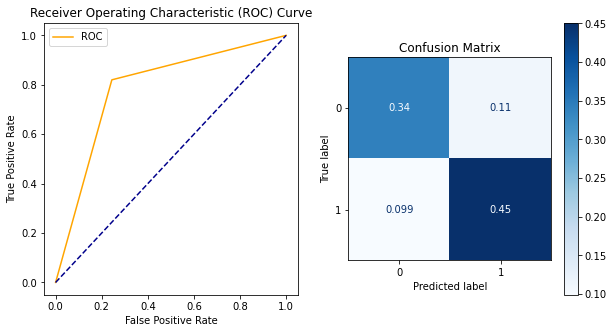

In [14]:
fper, tper, thresholds = metrics.roc_curve(yy, y_pred)
fig,ax=plt.subplots(figsize=(10,5),nrows=1,ncols=2)
ax[0].plot(fper, tper, color='orange', label='ROC')
ax[0].plot([0, 1], [0, 1], color='darkblue', linestyle='--')
ax[0].set_xlabel('False Positive Rate')
ax[0].set_ylabel('True Positive Rate')
ax[0].set_title('Receiver Operating Characteristic (ROC) Curve')
ax[0].legend()
metrics.plot_confusion_matrix(pipe, xx, yy,cmap=plt.cm.Blues, normalize = 'all',ax=ax[1])
ax[1].set_title('Confusion Matrix')